In [ ]:
import numpy as np
from matplotlib import pyplot as plt
dt = 0.1 
T = 10 
omega = 1.0  
acc_z = 1.0 
acc_x = 1.0

time = np.arange(0, T + dt, dt)


delta_orientation = np.zeros((len(time), 3))
delta_orientation[:, 2] = omega * dt 

filtered_acceleration = np.zeros((len(time), 3))
filtered_acceleration[:, 2] = acc_z
filtered_acceleration[:, 0] = acc_x

gravity_world = np.array([0, 0, -9.81])  

In [2]:
def rotation_matrix(roll, pitch, yaw):
    c_yaw, s_yaw = np.cos(yaw), np.sin(yaw)  
    c_pitch, s_pitch = np.cos(pitch), np.sin(pitch)  
    c_roll, s_roll = np.cos(roll), np.sin(roll)  
    
    R = np.array([
        [c_yaw * c_pitch, c_yaw * s_pitch * s_roll - s_yaw * c_roll, c_yaw * s_pitch * c_roll + s_yaw * s_roll],
        [s_yaw * c_pitch, s_yaw * s_pitch * s_roll + c_yaw * c_roll, s_yaw * s_pitch * c_roll - c_yaw * s_roll],
        [-s_pitch, c_pitch * s_roll, c_pitch * c_roll]
    ])
    
    return R

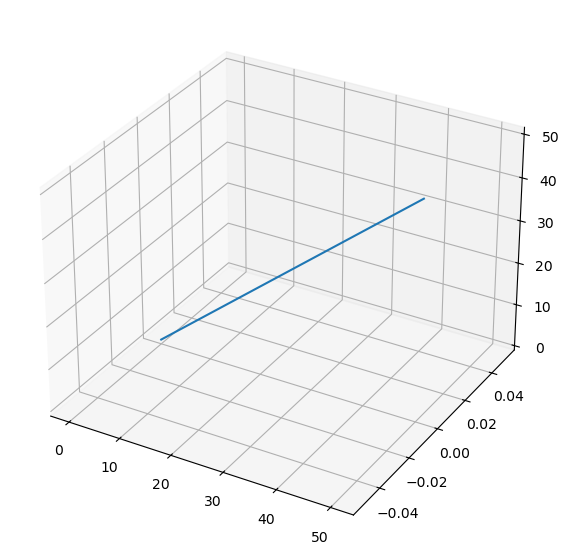

In [ ]:
t_prev = time[0]
total_rotation = np.eye(3)  
gravity_world = np.array([0, 0, -9.81])
vel_prev = filtered_acceleration[0] * time[0]
position = [vel_prev*time[0]]
t_prev = 0
for t, ac in zip(time[1:], filtered_acceleration[1:]):
    dt = t - t_prev
    vel = vel_prev + ac*dt 
    position.append(position[-1] + vel*dt)
    vel_prev = vel
    t_prev = t
    
position = np.array(position)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
# Plot the trajectory
ax.plot(position[:,0], position[:,1], position[:,2], label="Trajectory")
total_rotation = [np.eye(3)]
for t, delta in zip(time, delta_orientation):
    total_rotation.append(rotation_matrix(*delta) @ total_rotation[-1])


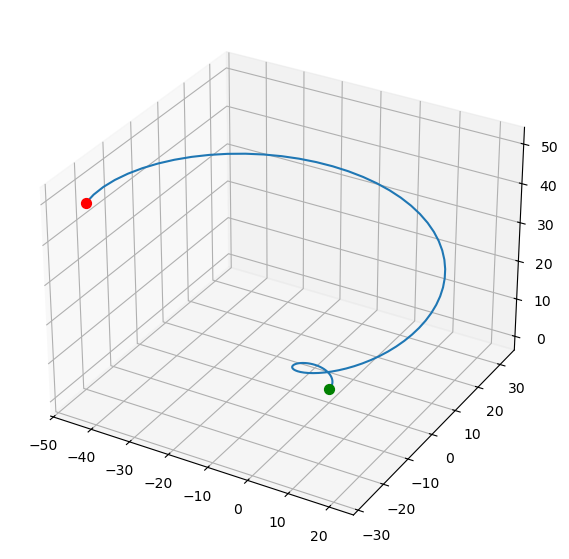

In [4]:
trajectory = []
for a,(pos, rot) in enumerate(zip(position, total_rotation)):
    new_pos_world = rot @ pos
    trajectory.append(new_pos_world)

trajectory = np.array(trajectory)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
# Plot the trajectory
ax.plot(trajectory[:,0], trajectory[:,1], trajectory[:,2], label="Trajectory") 
ax.scatter(trajectory[0,0], trajectory[0,1], trajectory[0,2], color="green", label="Start", s=50)  # Start point
ax.scatter(trajectory[-1,0], trajectory[-1,1], trajectory[-1,2], color="red", label="End", s=50)  # End point

In [5]:
# import matplotlib.pyplot as plt

# # Extract computed trajectory
# positions = np.array(position)

# # Analytical trajectory
# x_analytical = np.cos(omega * time)
# y_analytical = np.sin(omega * time)
# z_analytical = 0.5 * acc_z * time**2

# # Plot results
# fig = plt.figure(figsize=(10, 6))
# ax = fig.add_subplot(111, projection='3d')
# ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], label="Computed Trajectory")
# ax.plot(x_analytical, y_analytical, z_analytical, '--', label="Analytical Trajectory")
# ax.set_xlabel("X")
# ax.set_ylabel("Y")
# ax.set_zlabel("Z")
# ax.legend()
# plt.show()
